In [2]:
import numpy as np
import pandas as pd 
import netCDF4
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import fsspec
import s3fs
import zarr
import cfgrib
from urllib.request import urlopen
import netCDF4 as nc
from pyPRISMClimate import get_prism_daily_single


ModuleNotFoundError: No module named 'matplotlib.backends.registry'

In [2]:
################################# Data processing for the Livneh data ######################################

import requests
import xarray as xr

def download_file(url, local_filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename

year = 2016  # replace with the desired year
livneh_url = f'https://cirrus.ucsd.edu/~pierce/nonsplit_precip/precip/livneh_unsplit_precip.2021-05-02.{year}.nc'

local_filename = 'livneh_unsplit_precip.nc'
download_file(livneh_url, local_filename)

# Open the netCDF file using xarray
dataset = xr.open_dataset(local_filename)

print('done')
print(dataset)


done
<xarray.Dataset> Size: 599MB
Dimensions:  (Time: 366, lat: 444, lon: 922)
Coordinates:
  * Time     (Time) datetime64[ns] 3kB 2016-01-01 2016-01-02 ... 2016-12-31
  * lat      (lat) float64 4kB 25.16 25.22 25.28 25.34 ... 52.72 52.78 52.84
  * lon      (lon) float64 7kB -124.6 -124.5 -124.5 ... -67.16 -67.09 -67.03
Data variables:
    PRCP     (Time, lat, lon) float32 599MB ...
Attributes:
    missing_value:  -1e+36
    history:        Sun May  2 15:40:25 2021: ncks --mk_rec_dmn Time bad_not_...
    NCO:            4.7.2


In [3]:
# function for the livneh dataset
def get_xarray_info(file_path):
    # Open the NetCDF file
    time2 = file_path.Time.values
    #print(len(time))
    
    precip = file_path['PRCP'].values
    #print(precip)

    liv_lats = file_path.lat.values
    liv_lon = file_path.lon.values

    # Close the NetCDF file
    dataset.close()

    return time2, precip, liv_lats, liv_lon
days, precip_array, liv_lats, liv_lon = get_xarray_info(dataset)

#print(precip_array)

In [4]:

# funciton tells you what number in the array the date is (basically the julian day minus 1)
def get_date_index(dates_array, target_date):
    # Convert target_date to numpy datetime64 for comparison if necessary
    target_date = np.datetime64(target_date)
    indices = np.where(dates_array == target_date)[0]
    if len(indices) > 0:
        return indices[0]
    else:
        return 'not found'
    

target_date = datetime(2016, 7, 7)  
index = get_date_index(days, target_date)

print(f"\nIndex of the target date {target_date} is: {index}")

target_date_precip = precip_array[index,:,:]

########################################### End of Livneh data processing ##########################################


Index of the target date 2016-07-07 00:00:00 is: 188


In [5]:
########################################## AORC Data processing ################################################

base_url = f's3://noaa-nws-aorc-v1-1-1km'
year = '2016'
single_year_url = f'{base_url}/{year}.zarr/'
ds_single = xr.open_zarr(fsspec.get_mapper(single_year_url, anon=True), consolidated=True) # loads data into an xarray grid

var='APCP_surface' # precipitation variable 
ds = ds_single[var]
print(ds)


<xarray.DataArray 'APCP_surface' (time: 8784, latitude: 4201, longitude: 8401)> Size: 2TB
dask.array<open_dataset-APCP_surface, shape=(8784, 4201, 8401), dtype=float64, chunksize=(144, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 34kB 20.0 20.01 20.02 ... 54.98 54.99 55.0
  * longitude  (longitude) float64 67kB -130.0 -130.0 -130.0 ... -60.01 -60.0
  * time       (time) datetime64[ns] 70kB 2016-01-01 ... 2016-12-31T23:00:00
Attributes:
    AORC_Contact:  aorc.info@noaa.gov
    aorc_version:  v1.1
    crs:           EPSG:4326
    level:         surface
    long_name:     Total Precipitation
    short_name:    APCP_surface
    units:         kg/m^2


In [6]:
# Select a specific time range
begin = '2016-07-06T13:00:00'
end = '2016-07-07T12:00:00'
time_range = slice(begin, end)
data_range = ds.sel(time=time_range)

# Compute the sum of precipitation over the selected time range
data_sum = data_range.sum(dim='time')

aorc_lat = data_sum['latitude'].values
aorc_lon = data_sum['longitude'].values
aorc_precip = data_sum.values

#print(aorc_precip)
################################################# End of AORC processing ####################################

In [7]:
print(aorc_precip)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# data request for time period that you want
year = 2016
month = 7
day = 7
obs_end = datetime(year, month, day) # set year, month, and day you want data for

In [9]:
######################### MRMS Data processing #########################
'''
import requests
import gzip
import io

# data request for time period that you want
year = 2003
month = 5
day = 7
obs_end = datetime(year, month, day) # set year, month, and day you want data for


def download_and_extract_gz(url):
    
     # Make the HTTP request to get the file
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Decompress the .gz file
        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz_file:
            # Read the decompressed file content
            file_content = gz_file.read()
            return file_content
    else:
        raise Exception(f"Failed to download file. HTTP status code: {response.status_code}")

def read_grib_data(file_content):
    # Write the content to a temporary file
    with open('temporary.grib', 'wb') as temp_file:
        temp_file.write(file_content)
    
    # Open the GRIB file using xarray
    ds = xr.load_dataset('temporary.grib', engine="cfgrib")
    return ds


# Example usage
url = "https://mtarchive.geol.iastate.edu/{obs_end:%Y/%m/%d}/mrms/ncep/RadarOnly_QPE_24H/RadarOnly_QPE_24H_00.00_{obs_end:%Y%m%d}-120000.grib2.gz".format(obs_end=obs_end)

file_content = download_and_extract_gz(url)

# Read the GRIB data
ds = read_grib_data(file_content)

print(ds)

mrms_lat = ds['latitude'].values
mrms_lon = ds['longitude'].values
mrms_precip = ds['unknown'].values
'''
##################################### End of MRMS processing ############################


'\nimport requests\nimport gzip\nimport io\n\n# data request for time period that you want\nyear = 2003\nmonth = 5\nday = 7\nobs_end = datetime(year, month, day) # set year, month, and day you want data for\n\n\ndef download_and_extract_gz(url):\n    \n     # Make the HTTP request to get the file\n    response = requests.get(url)\n    \n    # Check if the request was successful\n    if response.status_code == 200:\n        # Decompress the .gz file\n        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz_file:\n            # Read the decompressed file content\n            file_content = gz_file.read()\n            return file_content\n    else:\n        raise Exception(f"Failed to download file. HTTP status code: {response.status_code}")\n\ndef read_grib_data(file_content):\n    # Write the content to a temporary file\n    with open(\'temporary.grib\', \'wb\') as temp_file:\n        temp_file.write(file_content)\n    \n    # Open the GRIB file using xarray\n    ds = xr.l

In [10]:
################################# Stage IV Processing ##################################
# reads in data file from url
url2 = 'https://water.noaa.gov/resources/downloads/precip/stageIV/{obs_end:%Y/%m/%d}/nws_precip_1day_{obs_end:%Y%m%d}_conus.nc'.format(obs_end=obs_end)
print(url2)
s4data = urlopen(url2).read()

df_qpe = nc.Dataset('data', memory=s4data)

# extract desired variables from file
precip_mapping = df_qpe.variables['observation']


stageIV_precip = df_qpe.variables['observation'][:,:] #gridded rainfall amounts (in inches)
stageIV_precip = stageIV_precip*25.4 # conversion to mm

x = df_qpe.variables['x'][:] # in meters (because it's in a projected coordinate system)
y = df_qpe.variables['y'][:]

x, y = np.meshgrid(x,y) # meshes the coordinates together into pairs (important for transforming the coordinates)


https://water.noaa.gov/resources/downloads/precip/stageIV/2016/07/07/nws_precip_1day_20160707_conus.nc


c:\Users\domenicbrooks\AppData\Local\anaconda3\Lib\site-packages\numpy\ma\core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [11]:
from pyproj import Proj, transform
proj_var = df_qpe.variables[precip_mapping.grid_mapping] # get the projection for the plot

globe = ccrs.Globe(semimajor_axis=proj_var.earth_radius) # globe shape used (like ellipsoid shape)
proj_meters = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=proj_var.straight_vertical_longitude_from_pole,
                          true_scale_latitude=proj_var.standard_parallel, globe=globe)

# WGS84 geographic coordinate system
proj_degrees = Proj(proj='latlong', datum='WGS84')


# Transform from projected coordinates (meters) to geographic coordinates (degrees)
stageIV_lon, stageIV_lat = transform(proj_meters, proj_degrees, x, y)

####################################### End of Stage IV processing ##################################

C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_25880\3132214725.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  stageIV_lon, stageIV_lat = transform(proj_meters, proj_degrees, x, y)


In [12]:
######################################### PRISM Data processing ###########################################
# downloads the PRISM data for the day you want
get_prism_daily_single('ppt', '{obs_end:%Y-%m-%d}'.format(obs_end=obs_end), return_path=False, dest_path=r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\prism")

In [13]:
def read_hdr_file(hdr_path):
    """
    Reads a .hdr file and returns metadata as a dictionary.
    
    :param hdr_path: Path to the .hdr file
    :return: Dictionary containing metadata
    """
    metadata = {}
    with open(hdr_path, 'r') as file:
        for line in file:
            key, value = line.strip().split()
            metadata[key] = value
    return metadata

def read_bil_file(file_path, shape):
    """
    Reads a .bil file and returns the data as a numpy array.
    
    :param file_path: Path to the .bil file
    :param shape: Tuple of the data's shape (rows, cols)
    :return: numpy array of the data
    """
    data = np.fromfile(file_path, dtype=np.float32).reshape(shape)
    return data

def convert_to_xarray(data, metadata):
    """
    Converts numpy array data to xarray.DataArray using metadata.
    
    :param data: Numpy array data
    :param metadata: Dictionary containing metadata
    :return: xarray.DataArray
    """
    nrows = int(metadata['NROWS'])
    ncols = int(metadata['NCOLS'])
    x_start = float(metadata['ULXMAP'])
    y_start = float(metadata['ULYMAP'])
    x_step = float(metadata['XDIM'])
    y_step = float(metadata['YDIM'])

    x_coords = x_start + np.arange(ncols) * x_step
    y_coords = y_start - np.arange(nrows) * y_step  # y_step is typically negative

    return xr.DataArray(data, coords=[y_coords, x_coords], dims=["latitude", "longitude"])

def plot_data(data_array):
    """
    Plots the xarray.DataArray.
    
    :param data_array: xarray.DataArray
    """
    data_array.plot()
    plt.show()

# Example usage
hdr_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\prism\PRISM_ppt_stable_4kmD2_{obs_end:%Y%m%d}_bil.hdr".format(obs_end=obs_end)
bil_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\prism\PRISM_ppt_stable_4kmD2_{obs_end:%Y%m%d}_bil.bil".format(obs_end=obs_end)

# Read metadata from the .hdr file
metadata = read_hdr_file(hdr_path)

# Extract shape information
nrows = int(metadata['NROWS'])
ncols = int(metadata['NCOLS'])
shape = (nrows, ncols)

# Read the .bil data
data = read_bil_file(bil_path, shape)

# Convert to xarray.DataArray
data_array = convert_to_xarray(data, metadata)

# Plot the data
#plot_data(data_array)
#print(data_array)
data_array = data_array.where(data_array != -9999)
#print(data_array)
#data_array.plot()

prism_lat = data_array['latitude'].values
prism_lon = data_array['longitude'].values
prism_precip = data_array.values

#print(prism_precip)


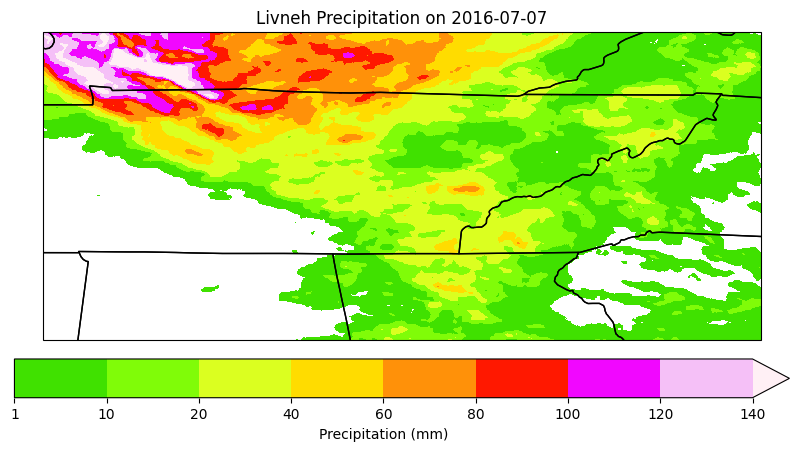

In [14]:

########################################################## Plotting the data
############################# Creating the colormap ###################################
# draw filled contours.
clevs = [1, 10, 20, 40, 60, 80, 100, 120, 140]

# makes first color in colorbar white
colormap = matplotlib.colormaps['gist_ncar']
newcolors = colormap(np.linspace(0, 1, 9))
#white = np.array([0, 0, 0, 0]) #rgb for white
#newcolors[:0, :] = white
cmap = mcolors.ListedColormap(colormap(np.linspace(0.35, 0.95, 9))) # selects range on colormap I want to use for my colors

norm = mcolors.BoundaryNorm(clevs, cmap.N) #normalizes the bounds for the color mapping

# set the colors above and below the max and min
cmap.set_under('white')
cmap.set_over('lavenderblush')


# Plot the data
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-88.543518, -81.263428, 34.114316, 37.240477], crs=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.LAND, edgecolor='black')
#ax.add_feature(cfeature.RIVERS)

# Plot the Livneh data
#im = ax.pcolormesh(liv_lon, liv_lats, target_date_precip, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Plot the AORC data
im = ax.pcolormesh(aorc_lon, aorc_lat, aorc_precip, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Plot the MRMS data
#im = ax.pcolormesh(mrms_lon, mrms_lat, mrms_precip, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Plot the MRMS data
#im = ax.pcolormesh(stageIV_lon, stageIV_lat, stageIV_precip, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# Plot PRISM Data
#im = ax.pcolormesh(prism_lon, prism_lat, prism_precip, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())


# Add color bar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, extend='max', label='Precipitation (mm)')


# Add title
plt.title(f'Livneh Precipitation on {target_date.strftime("%Y-%m-%d")}')

# Show the plot
plt.show()


done
done
done
done


C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_25880\917041134.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


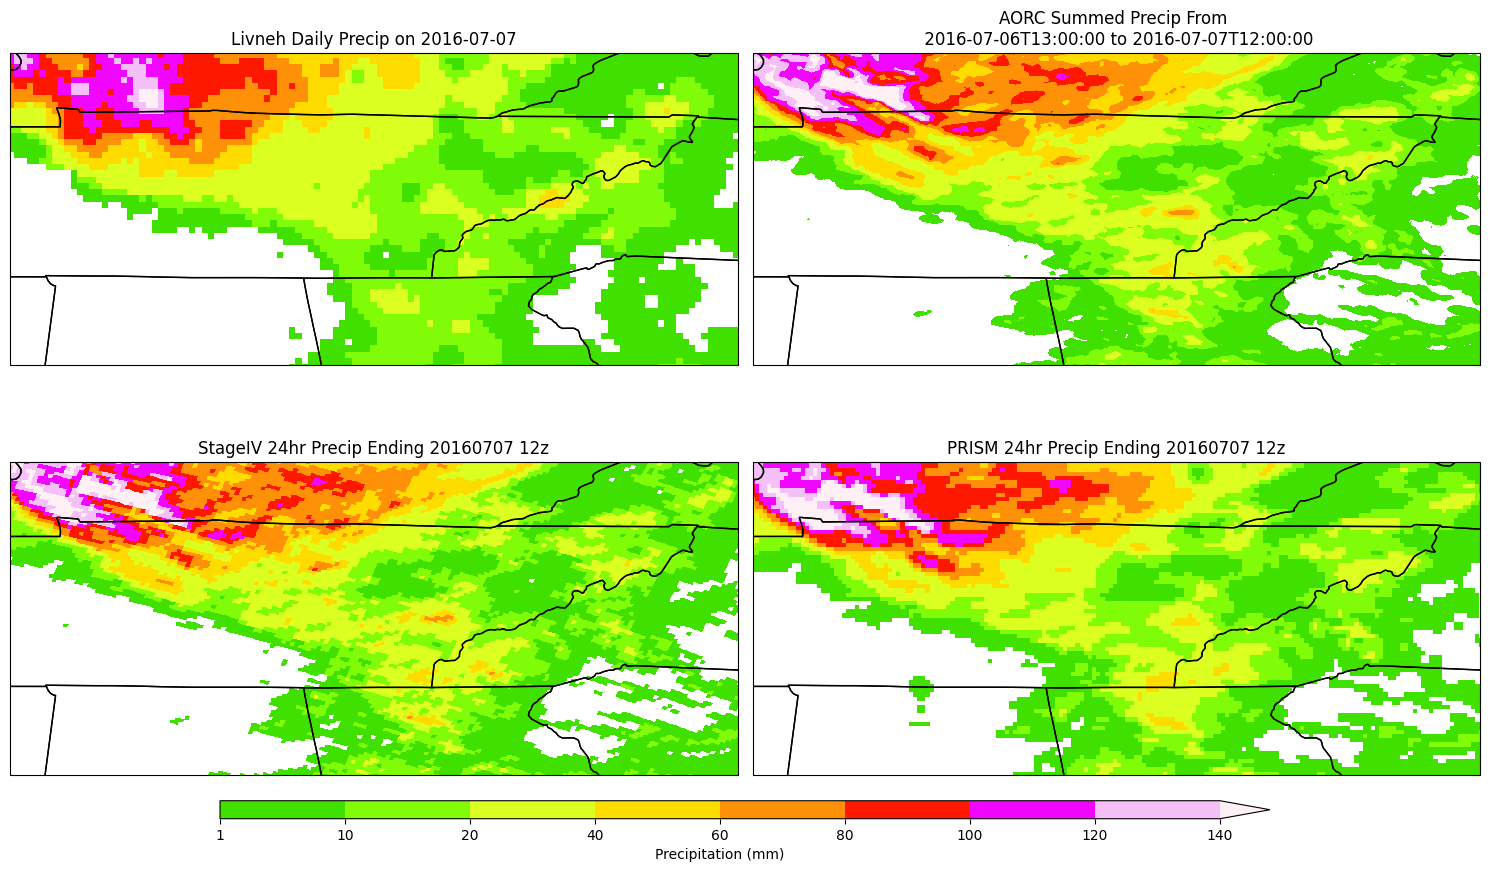

In [18]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent
extent = [-88.543518, -81.263428, 34.114316, 37.240477]

# List of data and titles
data = [
    (liv_lon, liv_lats, target_date_precip, 'Livneh Daily Precip on {0}'.format(target_date.strftime("%Y-%m-%d"))),
    (aorc_lon, aorc_lat, aorc_precip, 'AORC Summed Precip From \n {0} to {1}'.format(begin,end)),
    #(mrms_lon, mrms_lat, mrms_precip, 'MRMS 24hr Precip Ending {obs_end:%Y%m%d} 12z'.format(obs_end=obs_end)),
    (stageIV_lon, stageIV_lat, stageIV_precip, 'StageIV 24hr Precip Ending {obs_end:%Y%m%d} 12z'.format(obs_end=obs_end)),
    (prism_lon, prism_lat, prism_precip, 'PRISM 24hr Precip Ending {obs_end:%Y%m%d} 12z'.format(obs_end=obs_end))
]

# Iterate over the subplots and data
for ax, (lon, lat, precip, title) in zip(axs.flat, data):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    im = ax.pcolormesh(lon, lat, precip, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.set_title(title)
    print('done')

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])

# Add a colorbar
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', location='bottom', pad=0.05, extend='max', label='Precipitation (mm)')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
# Add a colorbar
fig.colorbar(im, ax=axs[0,3], orientation='horizontal', pad=0.05, extend='max', label='Precipitation (mm)')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

IndexError: index 3 is out of bounds for axis 1 with size 2